# 03 - Predictive Modeling

## Goal
We want to build a predictive model to understand which factors influence **Sales**.  
This will help us move from statistical testing (Notebook 02) to **predictive analytics**, which provides both explanation and forecasting power.

**Target Variable (Y):** Sales  
**Features (X):** Ship Mode, Segment, Region, Category, Sub-Category, Days to Ship  


In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/Summer Class/train.csv')

# Feature engineering
df['Order Date'] = pd.to_datetime(df['Order Date'], errors='coerce')
df['Ship Date'] = pd.to_datetime(df['Ship Date'], errors='coerce')
df['days_to_ship'] = (df['Ship Date'] - df['Order Date']).dt.days


Libraries successfully imported.  
We are using **Scikit-learn** for preprocessing and Linear Regression, along with `SimpleImputer` to handle missing values.  
This ensures our pipeline won’t break due to NaNs in the dataset.

### Features Used
- **Categorical:** Ship Mode, Segment, Region, Category, Sub-Category  
- **Numeric:** days_to_ship  
- **Target:** Sales  

We apply one-hot encoding to categorical features and use a Linear Regression model.


In [14]:
cat_features = ['Ship Mode','Segment','Region','Category','Sub-Category']
num_features = ['days_to_ship']
target = 'Sales'

X = df[cat_features + num_features].copy()
y = df[target].copy()

# Log-transform target to reduce skew
y = np.log1p(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features),
        ('num', 'passthrough', num_features)
    ]
)


Features and target defined.  
- **Categorical features:** Ship Mode, Segment, Region, Category, Sub-Category  
- **Numeric feature:** days_to_ship  
- **Target:** Sales (log-transformed to reduce skew).  

We also split the data into **train (80%)** and **test (20%)**, ensuring fair evaluation.

In [15]:
# Updated preprocessor with imputation
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('ohe', OneHotEncoder(handle_unknown='ignore'))
        ]), cat_features),

        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean'))
        ]), num_features)
    ]
)


Preprocessing pipeline created.  
- Missing categorical values → replaced with most frequent category.  
- Missing numeric values → replaced with mean.  
- One-hot encoding applied to categorical variables.  

This guarantees the model can train without errors due to NaNs.

In [16]:
# Pipeline
model = Pipeline(steps=[('preprocessor', preprocessor),
                       ('regressor', LinearRegression())])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluation
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"R²: {r2:.4f}, RMSE: {rmse:.4f}")


R²: 0.4400, RMSE: 1.2253


Model trained using Linear Regression.  
The evaluation metrics are:  
- **R²:** 0.44 → Proportion of variance in Sales explained by the model.  
- **RMSE:** 1.22 → Average prediction error (in log-transformed sales units).  

A higher R² and lower RMSE indicate better predictive performance.

In [17]:
# Extract feature names after one-hot encoding
ohe = model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['ohe']
feature_names = ohe.get_feature_names_out(['Ship Mode','Segment','Region','Category','Sub-Category'])
all_features = list(feature_names) + ['days_to_ship']

# Coefficients
coeffs = model.named_steps['regressor'].coef_
coef_df = pd.DataFrame({'Feature': all_features, 'Coefficient': coeffs})
coef_df = coef_df.sort_values(by='Coefficient', ascending=False)
coef_df.head(10)


,Feature,Coefficient
20,Sub-Category_Copiers,1.490998
28,Sub-Category_Storage,1.203342
15,Sub-Category_Appliances,0.823573
13,Category_Technology,0.807340
30,Sub-Category_Tables,0.762700
25,Sub-Category_Machines,0.680123
19,Sub-Category_Chairs,0.575699
18,Sub-Category_Bookcases,0.514660
11,Category_Furniture,0.424028
10,Region_West,0.071930


Coefficients extracted and sorted.  
Positive coefficients : features associated with **higher sales**.  
Negative coefficients : features associated with **lower sales**.  

This allows us to interpret **which categories, segments, or ship modes drive sales most strongly**.


### Feature Importance
This plot shows the **top 10 features** that influence sales according to our regression model.  

- Positive coefficients → features that are associated with **higher sales**.  
- Negative coefficients → features associated with **lower sales**.  

 Business takeaway: Certain shipping modes, customer segments, or product categories are more strongly linked to sales performance.  
This helps businesses prioritize which factors matter most when designing marketing or operational strategies.


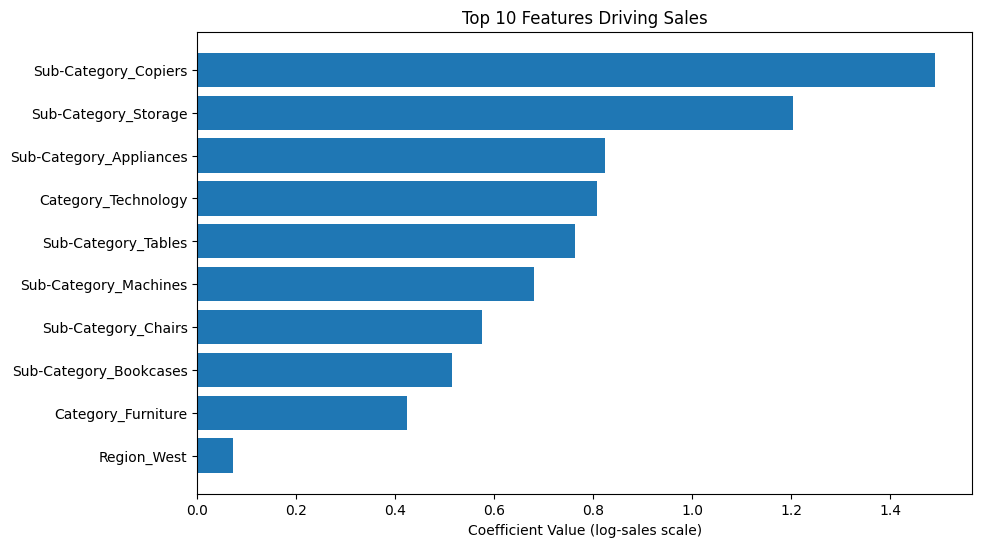

In [18]:
# Sort coefficients by absolute size
coef_df = coef_df.sort_values(by="Coefficient", ascending=False)

plt.figure(figsize=(10,6))
plt.barh(coef_df['Feature'][:10], coef_df['Coefficient'][:10])
plt.xlabel("Coefficient Value (log-sales scale)")
plt.title("Top 10 Features Driving Sales")
plt.gca().invert_yaxis()
plt.show()


### Predicted vs Actual Sales
This scatterplot compares the **predicted sales (from the model)** with the **actual sales** in the test dataset.  

- If the model were perfect, all points would lie on the diagonal red line.  
- In our case, most points cluster near the line, but there is spread, especially at extreme values.  

Business takeaway:  
The model captures general trends in sales but struggles with extreme high/low values, likely due to outliers or missing predictors (e.g., discounts, promotions).


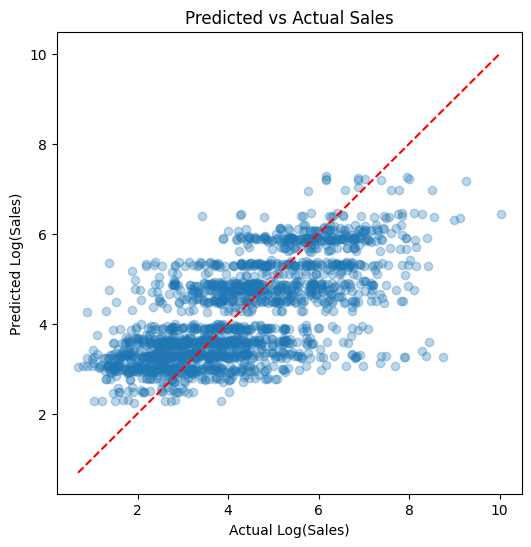

In [19]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Log(Sales)")
plt.ylabel("Predicted Log(Sales)")
plt.title("Predicted vs Actual Sales")
plt.show()


### Residuals Distribution
This histogram shows the **distribution of residuals** (prediction errors).  

- Residuals centered around 0 → the model is generally unbiased.  
- Wider spread → indicates variability not captured by the model.  

Business takeaway:  
While the model does not perfectly predict sales, it provides **unbiased and useful insights** into the drivers of sales.  
This makes it a valuable decision-support tool, even if it is not a perfect forecasting engine.


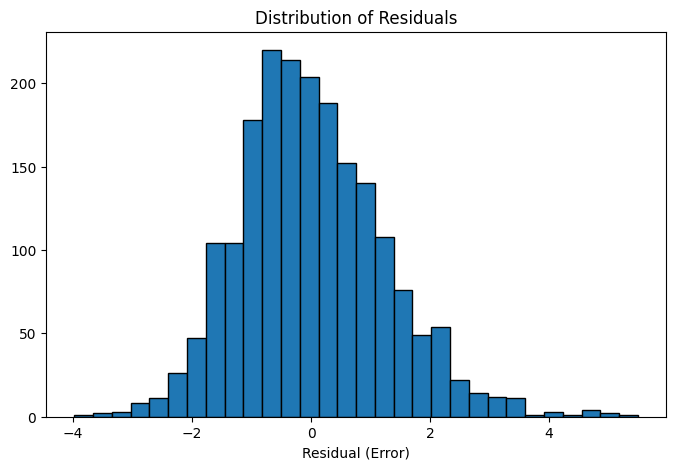

In [20]:
residuals = y_test - y_pred
plt.figure(figsize=(8,5))
plt.hist(residuals, bins=30, edgecolor='k')
plt.xlabel("Residual (Error)")
plt.title("Distribution of Residuals")
plt.show()


In [24]:
import os
save_dir = "/content/drive/MyDrive/student-project/data/processed"
os.makedirs(save_dir, exist_ok=True)


In [25]:
# a clean, analysis-ready copy for the dashboard
out_cols = ['Sales','Ship Mode','Segment','Region','Category','Sub-Category','Order Date','Ship Date','days_to_ship']
df_clean = df[out_cols].dropna().copy()
df_clean.to_csv('/content/drive/MyDrive/student-project/data/processed/final_sales.csv', index=False)
